In [206]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('insurance.csv')
print(df.head())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


In [46]:
df_reg = df.select_dtypes(include=['object']).copy()
print(df_reg.head())

      sex smoker     region
0  female    yes  southwest
1    male     no  southeast
2    male     no  southeast
3    male     no  northwest
4    male     no  northwest


In [47]:
labels_region = df_reg['region'].astype('category').cat.categories.tolist()
labels_smoker = df_reg['smoker'].astype('category').cat.categories.tolist()
labels_sex = df_reg['sex'].astype('category').cat.categories.tolist()

replace_region_comp = {'region' : {k: v for k,v in zip(labels_region,list(range(1,len(labels_region)+1)))}}
replace_smoker_comp = {'smoker' : {k: v for k,v in zip(labels_smoker,list(range(1,len(labels_smoker)+1)))}}
replace_sex_comp = {'sex' : {k: v for k,v in zip(labels_sex,list(range(1,len(labels_sex)+1)))}}

print(replace_region_comp)
print(replace_smoker_comp)
print(replace_sex_comp)

df_reg_replace=df_reg.copy()

df_reg_replace.replace(replace_region_comp, inplace=True)
df_reg_replace.replace(replace_smoker_comp, inplace=True)
df_reg_replace.replace(replace_sex_comp, inplace=True)

df=df.drop(['sex', 'smoker', 'region'],axis=1)

df=df.join(df_reg_replace)

{'region': {'northeast': 1, 'northwest': 2, 'southeast': 3, 'southwest': 4}}
{'smoker': {'no': 1, 'yes': 2}}
{'sex': {'female': 1, 'male': 2}}


In [48]:
df.head()

,age,bmi,children,charges,sex,smoker,region
0,19,27.900,0,16884.92400,1,2,4
1,18,33.770,1,1725.55230,2,1,3
2,28,33.000,3,4449.46200,2,1,3
3,33,22.705,0,21984.47061,2,1,2
4,32,28.880,0,3866.85520,2,1,2


In [67]:
#Normalizing
normalized_df = df
normalized_df[df.columns] = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(df[df.columns]))

In [68]:
normalized_df.head()

,age,bmi,children,charges,sex,smoker,region
0,0.021739,0.321227,0.0,0.251611,0.0,1.0,1.000000
1,0.000000,0.479150,0.2,0.009636,1.0,0.0,0.666667
2,0.217391,0.458434,0.6,0.053115,1.0,0.0,0.666667
3,0.326087,0.181464,0.0,0.333010,1.0,0.0,0.333333
4,0.304348,0.347592,0.0,0.043816,1.0,0.0,0.333333


In [69]:
X=normalized_df.drop(columns=['charges'])
y = normalized_df.iloc[:, 3]

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [120]:
#INTERACTION TERMS
poly = PolynomialFeatures(degree=7, interaction_only = False, include_bias = True)
X_poly_train=poly.fit_transform(X_train)
X_poly_test=poly.fit_transform(X_test)

In [183]:
#Ridge Regression
ridge=Ridge()
parameters={'alpha':[1e-2, 3e-2, 0.07, 0.09, 1e-1, 1, 3, 4]}
ridge_regressor=GridSearchCV(ridge, parameters, scoring = 'neg_mean_squared_error', cv = 3)
ridge_regressor.fit(X_poly_train,y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.01, 0.03, 0.07, 0.09, 0.1, 1, 3, 4]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [184]:
ridge_regressor.best_score_

-0.0066690919122624525

In [185]:
ridge_regressor.best_params_

{'alpha': 3}

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


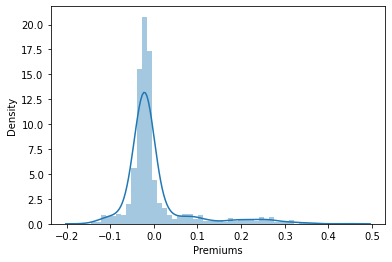

In [186]:
#DistPlot - Train

prediction_ridge=ridge_regressor.predict(X_poly_train)

sns.distplot(y_train-prediction_ridge, axlabel='Premiums')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


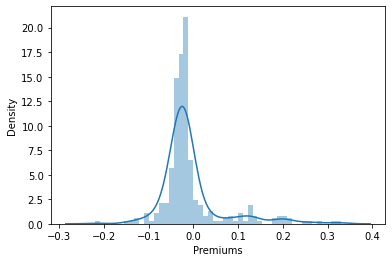

In [187]:
#DistPlot - Test
prediction_ridge=ridge_regressor.predict(X_poly_test)

sns.distplot(y_test-prediction_ridge, axlabel='Premiums')

In [202]:
#Train, Test scores
predict_train = ridge_regressor.predict(X_poly_train)
predict_test = prediction_ridge
r2scores=[r2_score(y_train, predict_train), r2_score(y_test, predict_test)]
rmse=[mean_squared_error(y_train, predict_train, squared = False), 
      mean_squared_error(y_test, predict_test, squared = False)]
mae=[mean_absolute_error(y_train, predict_train), mean_absolute_error(y_test, predict_test)]

In [203]:
dataset = pd.DataFrame(list(zip(r2scores,rmse,mae)), columns=['R2','RMSE','MAE'])

In [204]:
dataset

,R2,RMSE,MAE
0,0.841672,0.075923,0.045790
1,0.880886,0.069123,0.046004


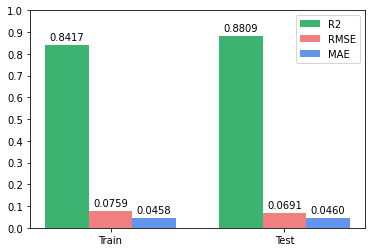

In [216]:
index = np.arange(2)
sets=['Train', 'Test']
bar_width = 0.25
score_label = np.arange(0, 1.1, 0.1)
fig, ax = plt.subplots()
barR2 = ax.bar(index-bar_width, r2scores, bar_width, label='R2', color = 'mediumseagreen')
barRMSE = ax.bar(index, rmse, bar_width, label='RMSE', color = 'lightcoral')
barMAE = ax.bar(index+bar_width, mae, bar_width, label='MAE', color = 'cornflowerblue')
ax.set_xticks(index)
ax.set_xticklabels(sets)
ax.set_yticks(score_label)
ax.legend()

def insert_data_labels(bars):
    for bar in bars:
        bar_height=bar.get_height()
        ax.annotate('{:.4f}'.format(bar.get_height()), 
                    xy=(bar.get_x() + bar.get_width()/2, bar_height), 
                    xytext=(0, 3), textcoords='offset points', ha='center',
                    va='bottom')

insert_data_labels(barR2)
insert_data_labels(barRMSE)
insert_data_labels(barMAE)

plt.show()